In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from msdm.domains.gridgame.tabulargridgame import TabularGridGame
from msdm.domains.gridworld.mdp import GridWorld
from msdm.algorithms.multiagentqlearning import TabularMultiAgentQLearner
from msdm.algorithms.friendfoeq import FriendFoeQ
from msdm.algorithms.correlatedq import CorrelatedQLearner
from msdm.algorithms.nashq import NashQLearner
from msdm.core.problemclasses.stochasticgame.policy.tabularpolicy import SingleAgentPolicy
from msdm.core.assignment.assignmentmap import AssignmentMap
import msdm
import numpy as np
import importlib
import itertools
import IPython.display as display

In [3]:
three_player_gamestring = """
# # # # # # # 
# A1 . A2 . A0 #
# . . . . . # 
# G1 . G2 . G0 #
# # # # # # #  
""".strip()

two_player = """
# # # # #
# . G . # 
# . . . #
# A0.~ . A1.~ #
# # # # #
"""
# gg = TabularGridGame(three_player_gamestring,agent_symbols=("A0","A1","A2"),goal_symbols=(
#                      ("G0", ("A0", )),
#                      ("G1", ("A1", )),
#                      ("G2",("A2", )),
#                      ("G", ("A0", "A1"))),)
gg = TabularGridGame(two_player,agent_symbols=("A0","A1"),goal_symbols=(("G",("A0","A1")),),step_cost=0,collision_cost=-1,goal_reward=100)
gg.state_list
print("State list generated")

State list generated


In [4]:
random_policy = AssignmentMap()
for state in gg.state_list:
    actions = list(gg.joint_actions(state)["A1"])
    random_policy[state] = AssignmentMap()
    for action in actions:
        random_policy[state][action] = 1.0/len(actions)
random_policy = SingleAgentPolicy("A1",gg,random_policy)

In [5]:
all_agents = ["A0","A1"]
learning_agents = ["A0","A1"]
friends = {"A1":[],"A0":[]}
foes = {"A1":["A0"],"A0":["A1"]}
# other_policies = {"A0":random_policy}
other_policies = {}
params = {"num_episodes":5000,"epsilon":.01,"epsilon_decay":1.0,"discount_rate":.99,
          "learning_rate":0.01,"show_progress":True,"render":False,"render_from":0,"default_q_value":1.0}

In [6]:
q_learner = TabularMultiAgentQLearner(learning_agents,other_policies,all_actions=True,alg_name="Q-Learning",**params)
ffq_learner = FriendFoeQ(learning_agents,friends,foes,other_policies,alg_name="FFQ-Learning",**params)
libertarian_q_learner = CorrelatedQLearner(learning_agents,other_policies,objective_func="Libertarian",alg_name="Libertarian CEQ",**params)
utilitarian_q_learner = CorrelatedQLearner(learning_agents,other_policies,objective_func="Utilitarian",alg_name="Utilitarian CEQ",**params)
republican_q_learner = CorrelatedQLearner(learning_agents,other_policies,objective_func="Republican",alg_name="Republican CEQ",**params)
egalitarian_q_learner = CorrelatedQLearner(learning_agents,other_policies,objective_func="Egalitarian",alg_name="Egalitarian CEQ",**params)
nash_q_learner = NashQLearner(learning_agents,other_policies,alg_name="Nash-Q Learning",**params)
# algorithms = [q_learner,ffq_learner,utilitarian_q_learner,republican_q_learner,egalitarian_q_learner,libertarian_q_learner,nash_q_learner]
# algorithms = [q_learner,ffq_learner,utilitarian_q_learner,republican_q_learner,egalitarian_q_learner,libertarian_q_learner]
algorithms = [ffq_learner]

In [7]:
results = []
example_trajectories = []
for alg in algorithms:
    res = alg.plan_on(gg)
    results.append(res)
    trajectory = res.pi.run_on(gg,maxSteps=10)
    example_trajectories.append(trajectory)

  8%|▊         | 6/74 [00:00<00:01, 59.38it/s]

{'A0': 99.98998990090003, 'A1': 99.9899899009}


 16%|█▌        | 12/74 [00:00<00:01, 57.29it/s]

{'A0': 98.99009000189103, 'A1': 98.9900900018909}


 16%|█▌        | 12/74 [00:00<00:01, 55.37it/s]

{'A0': 98.00017920374523, 'A1': 98.00017920374508}


  9%|▉         | 7/74 [00:00<00:01, 60.28it/s]

{'A0': 97.02016761256311, 'A1': 0.9702795941170308}


  8%|▊         | 6/74 [00:00<00:01, 57.96it/s]

{'A0': 23.535082450139186, 'A1': 0.9605671924078933}


 12%|█▏        | 9/74 [00:00<00:01, 44.97it/s]

{'A0': 0.4754902697852543, 'A1': 0.4754925875672029}


100%|██████████| 74/74 [00:01<00:00, 60.66it/s]


{'A0': 1.6475620142841763e-05, 'A1': 1.6475623013434415e-05}
Planning for FFQ-Learning Complete


Calculating Projected Q-Values: 100%|██████████| 74/74 [00:00<00:00, 4950.85it/s]


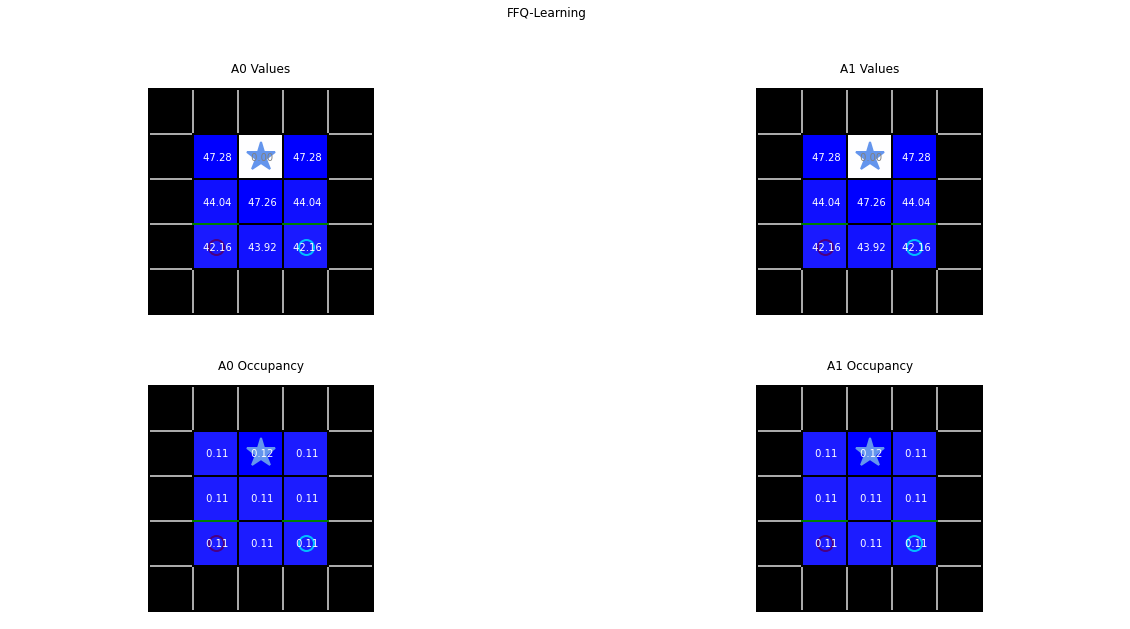

In [8]:
for k,alg in enumerate(algorithms): 
    fig,axes = plt.subplots(2,len(all_agents),figsize=(20,10))
    fig.suptitle(alg.alg_name)
    for i,agent_name in enumerate(all_agents):
        plotter = gg.plot(ax=axes[0][i])
        plotter.title(agent_name + " Values")
        q_matrix = results[k].pi.single_agent_policies[agent_name].q_matrix
        occupancy_matrix = results[k].pi.occupancy_matrix
        occupancy_matrix.fill(1.0/len(occupancy_matrix[0]))
        initial_state = gg.initial_state_dist().sample()
        initial_index = gg.state_list.index(initial_state)
#         plotter.plot_state_action_map(results[k].pi.positionActionMapping(agent_name,q_matrix,occupancy_matrix,initial_state))
        plotter.plot_state_map(results[k].pi.positionMapping(agent_name,q_matrix,occupancy_matrix,initial_state))
        plotter = gg.plot(ax=axes[1][i])
        plotter.title(agent_name + " Occupancy")
        plotter.plot_weights(results[k].pi.weightMapping(agent_name,occupancy_matrix,initial_state))

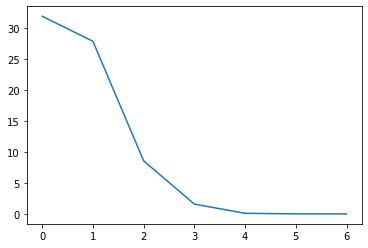

In [9]:
for k,alg in enumerate(algorithms): 
    plt.plot(alg.errors)

In [10]:
animations = []
for k,alg in enumerate(algorithms):
    fig, axes = plt.subplots(1,1,figsize=(20,10))
    fig.suptitle(alg.alg_name)
    trajectory = results[k].pi.run_on(gg,maxSteps=10)
    animator = gg.animate(figure=fig,ax=axes)
    animation = animator.animate_trajectory(trajectory)
    animations.append(animation)
display.display(*[display.HTML(animation.to_jshtml()) for animation in animations])
plt.close()